In [11]:
import tensorflow as tf
import numpy as np
from tqdm import trange, tqdm
# %matplotlib inline

import os
os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import model_to_dot
from callbacks import all_callbacks

In [13]:
import pydot

### Make the model architectures 

In [14]:
K = 8

model_with_dense = Sequential([
    Dense(K, input_shape=(K,), name='dense'),
    BatchNormalization(),
])

dense_layer = model_with_dense.layers[0]

dense_layer.set_weights([np.eye(K), np.zeros(K)])
dense_layer.trainable = False
# print(dense_layer.weights)

model_without_dense = Sequential([
    BatchNormalization(input_shape=(K,)),
])


model_with_dense.save_weights('untrained_model_with_dense.h5')
model_without_dense.save_weights('untrained_model_without_dense.h5')


In [15]:
import plotting
import matplotlib.pyplot as plt

## Test Different Training Sizes

In [16]:
import sys
import os
from contextlib import redirect_stdout
import hls4ml
import copy

### Util Functions

In [17]:
batch_size = 1
epochs = 1

# Trains the keras model and returns the trained model
def train_software_model(model, data_x, data_y, untrained_model_path):
    model.load_weights(untrained_model_path)
    adam_W = AdamW(learning_rate=0.0001)
    model.compile(optimizer=adam_W, loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    # Train the model
    model.fit(
        data_x,
        data_y,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0,
        shuffle=True,
        verbose=0
    )

    return model


# Compiles the keras model into an hls4ml model
def compile_hls4ml_model(model):
    
    with open(os.devnull, 'w') as fnull: # Disable stdout
        with redirect_stdout(fnull):
            config = hls4ml.utils.config_from_keras_model(
                model,
                default_precision='fixed<64,32>',
                granularity='name'
            )
            hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config)    
            hls_model.compile()

    return hls_model


def get_software_model_output(model, data_x):
    output = model.predict(data_x, verbose=0)
    means = np.mean(output, axis=1)
    vars = np.var(output, axis=1)
    mean_mean = np.mean(means)
    mean_var = np.mean(vars)
    output = output.flatten().tolist()
    return mean_mean, mean_var, output


# Compiles the hls4ml model and runs the model on the data
def get_hls4ml_model_output(model, data_x, printing=False):
    hls_model = compile_hls4ml_model(model)
    layers = hls_model.get_layers()
    if printing:
        print("WEIGHTS:")
        for layer in layers:
            map = layer.get_weights()
            for thing in map:
                print(thing.data)
    hls_output = hls_model.predict(data_x)
    if len(hls_output.shape) == 1:
        hls_output = hls_output.reshape((hls_output.shape[0], 1))
    output = hls_output
    if printing:
        print(output)
    means = np.mean(output, axis=1)
    vars = np.var(output, axis=1)
    mean_mean = np.mean(means)
    mean_var = np.mean(vars)
    hls_output = output.flatten().tolist()
    return mean_mean, mean_var, hls_model, hls_output


def store_results(results, software_model, untrained_software_output, trained_software_output, untrained_hls4ml_output, trained_hls4ml_output, test_data_x):
    
    results['software']['trained']['models'].append(software_model)
    results['hls4ml']['trained']['models'].append(trained_hls4ml_output[2])

    results['software']['untrained']['means'].append(untrained_software_output[0])
    results['software']['untrained']['vars'].append(untrained_software_output[1])
    results['software']['trained']['means'].append(trained_software_output[0])
    results['software']['trained']['vars'].append(trained_software_output[1])

    results['hls4ml']['untrained']['means'].append(untrained_hls4ml_output[0])
    results['hls4ml']['untrained']['vars'].append(untrained_hls4ml_output[1])
    results['hls4ml']['trained']['means'].append(trained_hls4ml_output[0])
    results['hls4ml']['trained']['vars'].append(trained_hls4ml_output[1])

    if 'inputs' not in results:
        results['inputs'] = []

    results['inputs'].append(test_data_x)

    results['software']['untrained']['outputs'].append(untrained_software_output[2])
    results['software']['trained']['outputs'].append(trained_software_output[2])

    results['hls4ml']['untrained']['outputs'].append(untrained_hls4ml_output[3])
    results['hls4ml']['trained']['outputs'].append(trained_hls4ml_output[3])

### Custom Batchnormalization testing

In [18]:
import numpy as np

In [19]:
num = 5_000

input_mean = 50
input_std = 4

MEAN_STEP_SIZE = 50
STD_DEV_STEP_SIZE = 5

means = [input_mean + (i * MEAN_STEP_SIZE) for i in range(K)]
stds = [input_std + STD_DEV_STEP_SIZE for i in range(K)]

data_x = np.array(
    [np.random.normal(loc=means[i], scale=stds[i], size=(num,)) for i in range(K)]
    ).T
data_y = np.random.uniform(0, 1, size=(num, K))

# print("data_x[0]: ", data_x[0])
print("data_x.shape: ", data_x.shape)

print("largest number: ", np.max(data_x))
print("smallest number: ", np.min(data_x))

print()
print("largest numbers: ", np.max(data_x, axis=0))
print("smallest numbers: ", np.min(data_x, axis=0))


data_x.shape:  (5000, 8)
largest number:  437.5829052956423
smallest number:  18.36298133816563

largest numbers:  [ 78.48665099 130.38266338 188.33225244 244.87907601 280.49067736
 331.46530201 378.13327931 437.5829053 ]
smallest numbers:  [ 18.36298134  66.73604725 115.20685406 166.15954263 217.171427
 270.63111399 317.75889827 367.14995038]


In [20]:
import sys
import os

# Add the directory containing batchnorm.py to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'new-batchnorm')))

# Now you can import batchnorm
import batchnorm


# make 90/10 test split
split = int(0.9 * len(data_x))
train_data_x = data_x[:split]
train_data_y = data_y[:split]
test_data_x = data_x[split:]
test_data_y = data_y[split:]

keras_batchnorm = BatchNormalization(input_shape=(K,), scale=False, center=False)

model_keras_batchnorm = Sequential([
    keras_batchnorm,
])


print("gamma: ", model_keras_batchnorm.layers[0].gamma)
print("beta: ", model_keras_batchnorm.layers[0].beta)


model_keras_batchnorm.compile(optimizer='adam', loss='MSE')

# trained_model = train_software_model(model_keras_batchnorm, train_data_x, train_data_y, 'untrained_model_without_dense.h5')
model_keras_batchnorm.fit(
    data_x,
    data_y,
    # batch_size=num,
    epochs=10,
    validation_split=0,
    shuffle=True,
    verbose=0
)

for trainable_weight in model_keras_batchnorm.trainable_weights:
    print(trainable_weight)

# print("trained_model weights:", model_keras_batchnorm.get_weights())
output = model_keras_batchnorm.predict(test_data_x, verbose=0)

print("train input shape", train_data_x.shape)
print("train output shape", train_data_y.shape)

print("test input shape:", test_data_x.shape)
print("test output shape:", output.shape)
print("test desired output shape:", test_data_y.shape)

# print("output:", output)

input_feature_wise_mean = np.mean(test_data_x, axis=0)
input_feature_wise_var = np.var(test_data_x, axis=0)
output_feature_wise_mean = np.mean(output, axis=0)
output_feature_wise_var = np.var(output, axis=0)


if True:
    print()
    print("input feature wise mean:", input_feature_wise_mean)
    print("input feature wise var:", input_feature_wise_var)
    print("output feature wise mean:", output_feature_wise_mean)
    print("output feature wise var:", output_feature_wise_var)
    print()

    print("means: ", means)
    print("vars: ", [stds[i] ** 2 for i in range(K)])
    print("moving mean: ", model_keras_batchnorm.layers[0].moving_mean)
    print("moving var: ", model_keras_batchnorm.layers[0].moving_variance)


handmade_batchnorm = batchnorm.HandmadeBatchNormalization(
    keras_batchnorm=keras_batchnorm,
)

model_handmade_batchnorm = Sequential([
    handmade_batchnorm,
])

model_handmade_batchnorm.compile(optimizer='adam', loss='MSE')

one_input = test_data_x[0].reshape((8, ))

if False:
    print("one_input.shape: ", one_input.shape)

    print("handmade_batchnorm.mean.shape: ", handmade_batchnorm.mean.shape)
    print("handmade_batchnorm.var.shape: ", handmade_batchnorm.var.shape)
    print("handmade_batchnorm.gamma.shape: ", handmade_batchnorm.gamma.shape)
    print("handmade_batchnorm.beta.shape: ", handmade_batchnorm.beta.shape)
    print()


hardware_model = compile_hls4ml_model(model_keras_batchnorm)


handmade_y = [handmade_batchnorm.call(test_data_x[i].reshape(8,)).reshape((K, 1)).T for i in range(test_data_x.shape[0])]
handmade_y = np.concatenate(handmade_y, axis=0)

print("handmade_y.shape:", handmade_y.shape)

keras_y = model_keras_batchnorm.predict(test_data_x, verbose=0)
hls4ml_y = hardware_model.predict(np.ascontiguousarray(test_data_x, dtype=np.float32))


print("handmade_y shape:", handmade_y.shape)
print("keras_y shape:", keras_y.shape)
assert(handmade_y.shape == keras_y.shape)

handmade_vs_keras = "SAME VALUES!!" if  np.allclose(handmade_y, keras_y, rtol=1e-02, atol=1e-02) else "DIFFERENT VALUES!!"
hls4ml_vs_keras = "SAME VALUES!!" if  np.allclose(hls4ml_y, keras_y, rtol=1e-02, atol=1e-02) else "DIFFERENT VALUES!!"

print(f"Keras vs handmade values: {handmade_vs_keras}")
print(f"Keras vs hls4ml values: {hls4ml_vs_keras}")

software_means = np.mean(keras_y, axis=0)
software_vars = np.var(keras_y, axis=0)

hardware_means = np.mean(hls4ml_y, axis=0)
hardware_vars = np.var(hls4ml_y, axis=0)

print("software means:", software_means)
print("software vars:", software_vars)
print("hardware means:", hardware_means)
print("hardware vars:", hardware_vars)

gamma:  None
beta:  None
train input shape (4500, 8)
train output shape (4500, 8)
test input shape: (500, 8)
test output shape: (500, 8)
test desired output shape: (500, 8)

input feature wise mean: [ 49.76843117  99.35786633 150.45365589 200.43967981 250.30550562
 299.79007058 350.35538436 400.12999123]
input feature wise var: [81.20842032 86.60832423 84.19652548 84.13413879 95.18968611 79.5970487
 88.70881514 82.10843884]
output feature wise mean: [-0.01432426 -0.06142802  0.04167307  0.03325552  0.0048161  -0.00347091
  0.0245126   0.00199973]
output feature wise var: [1.047053  1.1103293 1.0620606 1.1045411 1.1973677 1.0226198 1.1007442
 1.0556192]

means:  [50, 100, 150, 200, 250, 300, 350, 400]
vars:  [81, 81, 81, 81, 81, 81, 81, 81]
moving mean:  <tf.Variable 'batch_normalization_5/moving_mean:0' shape=(8,) dtype=float32, numpy=
array([ 49.89458,  99.90039, 150.08261, 200.14944, 250.26256, 299.82068,
       350.1353 , 400.11237], dtype=float32)>
moving var:  <tf.Variable 'batch_

#### Scatter plot of HLS vs keras

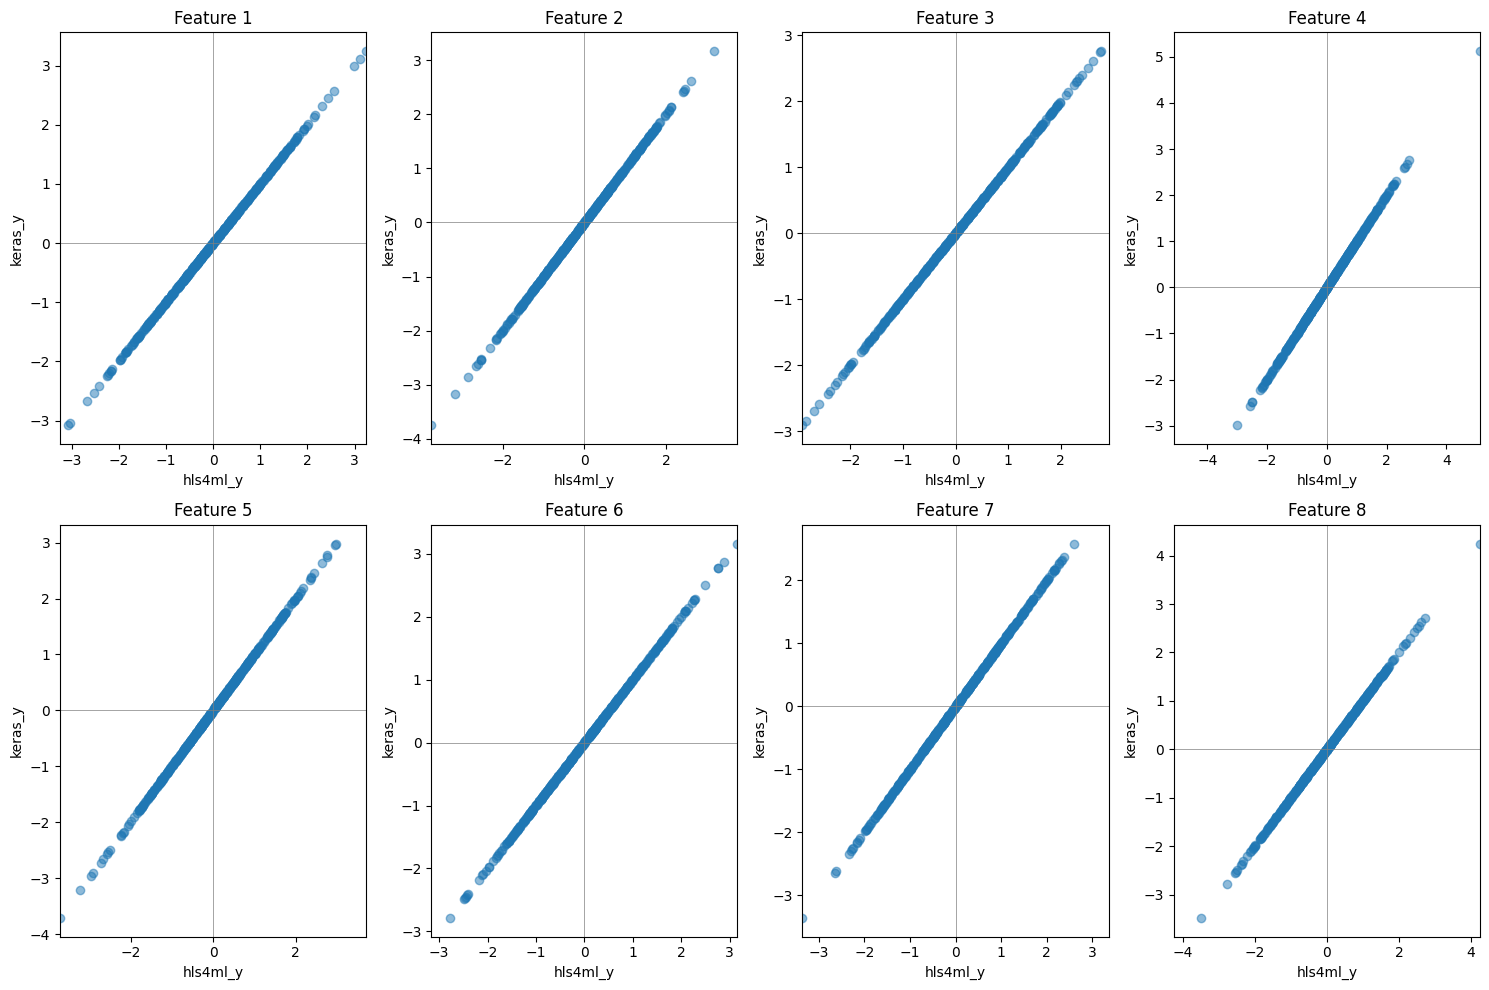

In [21]:
# Create a figure with 8 subplots
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature in a separate subplot
for i in range(8):
    axes[i].scatter(hls4ml_y[:, i], keras_y[:, i], alpha=0.5)
    axes[i].set_title(f'Feature {i+1}')
    axes[i].set_xlabel('hls4ml_y')
    axes[i].set_ylabel('keras_y')
    
    CENTER = True
    
    if CENTER:
    
        # Set limits to center the plots on 0
        max_val = max(abs(hls4ml_y[:, i]).max(), abs(keras_y[:, i]).max())
        axes[i].set_xlim(-max_val, max_val)
        # axes[i].set_ylim(-max_val, max_val)
        axes[i].axhline(0, color='gray', linewidth=0.5)
        axes[i].axvline(0, color='gray', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.show()

In [22]:
features = [6, 8]
for feature in features:
    # feature = 7
    feature_max = hls4ml_y[:, feature - 1].max()
    feature_min = hls4ml_y[:, feature - 1].min()


    print(f"max of feature {feature}:", feature_max)
    print(f"min of feature {feature}:", feature_min)
    print(f"difference between max and min of feature {feature}:", feature_max - feature_min)

max of feature 6: 3.164356
min of feature 6: -2.7854085
difference between max and min of feature 6: 5.9497643
max of feature 8: 4.2486396
min of feature 8: -3.4779873
difference between max and min of feature 8: 7.726627


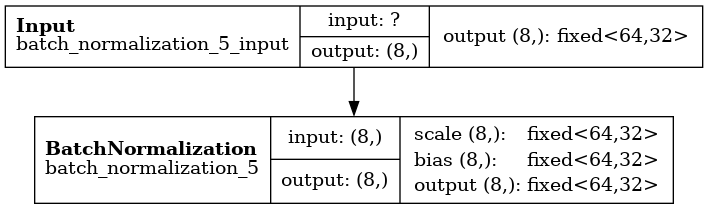

In [23]:
hls4ml.utils.plot_model(hardware_model, show_shapes=True, show_precision=True, to_file=None)

### Look Into different Bit Widths


In [24]:
# Compiles the keras model into an hls4ml model
def compile_hls4ml_model_with_bitwidth(model):
    
    with open(os.devnull, 'w') as fnull: # Disable stdout
        with redirect_stdout(fnull):
            config = hls4ml.utils.config_from_keras_model(
                model,
                default_precision='fixed<64,32>',
                granularity='name'
            )
            hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config)    
            hls_model.compile()

    return hls_model

### Test Custom Dense+BatchNorm
$\begin{align}
y &= W_1 x + b_1 \\
z &= W_2 y + b_2 \\
  &= W_2 (W_1 x + b_1) + b_2 \\
  &= W_2W_1x + (W_2b_1 + b_2) \\
  &= W_3x + b_3
\end{align}$

Where $W_3 = W_2W_1x$ and $b_3 = W_2b_1 + b_2$

32/32 [==============================] - 0s 2ms/step
keras_pred_y.shape: (1000, 32)
combined_pred_y.shape: (1000, 32)
keras_pred_y[0]: [  11.844448   -28.691597    21.682953    10.694241    44.580982
   32.825348   -36.304684    -5.778938    13.860965   144.28314
   78.82149     13.7217245   43.04741     31.974289   -13.029278
   24.215202   -53.49397    -24.780186  -149.99637   -141.65755
   63.45258    -53.411736    24.003279   -17.86635    -51.5059
  -28.160868    44.357677   -29.669668   -31.14299      7.561764
    5.0230956  -10.109024 ]
combined_pred_y[0]: tf.Tensor(
[  11.844454   -28.6916      21.682968    10.694255    44.58099
   32.825348   -36.304684    -5.77894     13.860966   144.28317
   78.821495    13.721724    43.04741     31.974283   -13.02929
   24.215204   -53.493984   -24.78019   -149.99641   -141.65755
   63.45256    -53.411728    24.003279   -17.86636    -51.5059
  -28.160889    44.35768    -29.669668   -31.142996     7.5617642
    5.0231037  -10.109032 ], shape=

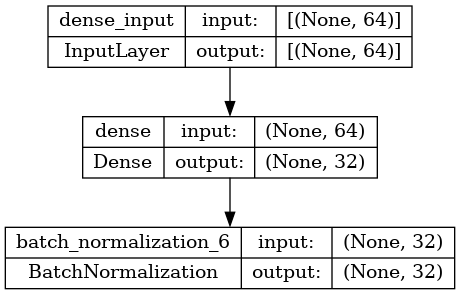

In [25]:
trash_data_x = np.random.normal(loc=50, scale=4, size=(1000, 64))
trash_data_y = np.random.uniform(0, 1, size=(1000, 32))

keras_dense_plus_batchnorm = Sequential([
    Dense(32, input_shape=(64,)),
    BatchNormalization(),
])

keras_dense_plus_batchnorm.compile(optimizer='adam', loss='MSE')

combined_dense_plus_batchnorm_layer = batchnorm.DenseWithBatchNormalization(
    input_dense = keras_dense_plus_batchnorm.layers[0],
    batchnorm = keras_dense_plus_batchnorm.layers[1],
)

keras_pred_y = keras_dense_plus_batchnorm.predict(trash_data_x)
print("keras_pred_y.shape:", keras_pred_y.shape)

combined_pred_y = combined_dense_plus_batchnorm_layer.call(trash_data_x)
print("combined_pred_y.shape:", combined_pred_y.shape)

print("keras_pred_y[0]:", keras_pred_y[0])
print("combined_pred_y[0]:", combined_pred_y[0])

if np.allclose(keras_pred_y, combined_pred_y, rtol=1e-02, atol=1e-02):
    print("SAME VALUES!!")
else:
    raise ValueError("DIFFERENT VALUES!!")

# print the visualization of the model
tf.keras.utils.plot_model(
    keras_dense_plus_batchnorm,
    to_file='model_dense_plus_batchnorm.png',
    show_shapes=True,
    # show_dtype=False,
    # show_layer_names=False,
    # rankdir='TB',
    # expand_nested=False,
    # dpi=200,
    # show_layer_activations=False,
    # show_trainable=False,
)


In [26]:
from tensorflow import Tensor

In [27]:
batchnorm_layer = list(hardware_model.get_layers())[1]
# print(type(batchnorm_layer))
print("layer.name: ", batchnorm_layer.name)

# print(dir(batchnorm_layer))
weights1 = list(batchnorm_layer.get_weights())
scale = weights1[0]
bias = weights1[1]

print("scale: ", scale)
print("bias: ", bias)

scale_weights = np.array(scale.data)
bias_weights = np.array(bias.data)

print("scale_weights: ", scale_weights)
print("bias_weights: ", bias_weights)

handmade_batchnorm_from_hls = batchnorm.HandmadeBatchNormalization(None, scale_weights, bias_weights)

handmade_y_from_hls = [handmade_batchnorm_from_hls.call(test_data_x[i].reshape(8,)).reshape((K, 1)).T for i in range(test_data_x.shape[0])]

handmade_y_from_hls = np.concatenate(handmade_y_from_hls, axis=0)
print("handmade_y_from_hls.shape:", handmade_y_from_hls.shape)

# for weight in weights1:
#     print(f"weight: {weight.name}. data: {weight.data}")
    
# print(batchnorm_layer.get_weights())

# weights2 = list(batchnorm_layer.weights)
# scale = weights2[0]
# bias = weights2[1]

# print("scale.name: ", scale.name)
# for weight in weights1:
#     print(f"weight: {weight.name}. data: {weight.data}")

print("handmade scale:", handmade_batchnorm.scale)
print("handmade bias:", handmade_batchnorm.bias)

layer.name:  batch_normalization_5
scale:  <hls4ml.backends.fpga.fpga_types.StaticWeightVariable object at 0x7f492a35c3a0>
bias:  <hls4ml.backends.fpga.fpga_types.StaticWeightVariable object at 0x7f492a35c2e0>
scale_weights:  [0.11354913 0.11322594 0.11231233 0.11457893 0.11215504 0.11334664
 0.11139349 0.11338607]
bias_weights:  [ -5.6654863 -11.311316  -16.856129  -22.932909  -28.068207  -33.983665
 -39.002796  -45.36717  ]
handmade_y_from_hls.shape: (500, 8)
handmade scale: [0.11354913 0.11322594 0.11231233 0.11457894 0.11215503 0.11334664
 0.11139349 0.11338607]
handmade bias: [ -5.6654861  -11.31131528 -16.85612789 -22.93291024 -28.06820585
 -33.98366651 -39.00279489 -45.36716841]


In [28]:
print("hls4ml_y shape:", hls4ml_y.shape)

index = 3
print("handmade_y[index]: ", handmade_y[index])
print("keras_y[index]: ", keras_y[index])
print("hls4ml_y[index]: ", hls4ml_y[index])
print("handmade_y_from_hls[index]: ", handmade_y_from_hls[index])

hls4ml_y shape: (500, 8)
handmade_y[index]:  [ 1.71127896 -2.1585465  -0.53356492 -0.51621629 -1.29466124  2.08959513
 -1.34021449 -0.4313603 ]
keras_y[index]:  [ 1.7112789  -2.1585464  -0.5335636  -0.5162163  -1.2946625   2.089592
 -1.3402138  -0.43135834]
hls4ml_y[index]:  [ 1.7112792  -2.1585467  -0.5335648  -0.5162164  -1.2946627   2.0895934
 -1.340215   -0.43135935]
handmade_y_from_hls[index]:  [ 1.71127879 -2.15854672 -0.5335656  -0.51621559 -1.29466205  2.08959503
 -1.34021631 -0.43135914]


### Data collection

In [29]:
printing = False

data = {'with_dense': {
        'base_model': model_with_dense,
        'untrained_weights': 'untrained_model_with_dense.h5',
    }, 'without_dense': {
        'base_model': model_without_dense,
        'untrained_weights': 'untrained_model_without_dense.h5',
    }
}

num_data_points = [10, 100, 1000, 5_000]
# num_data_points = [100]

### New Checking Batchnorm

In [30]:
import utils

In [31]:
from tqdm import tqdm

total_iterations = len(data) * len(num_data_points)


with tqdm(total=total_iterations) as pbar:

    for model in data:
        data[model]['results'] = {
            implementation: {
                scheme: {
                    'models': [],
                    'means': [],
                    'vars': [],
                    'outputs': [],
                } for scheme in ['untrained', 'trained']
            } for implementation in ['software', 'hls4ml']
        }

        for i, num in enumerate(num_data_points):
            input_mean = -50
            input_var = 5

            # Generate random data
            data_x = np.array(
                [np.random.normal(loc=input_mean + i * 10, scale=input_var + i, size=(K,)) for i in range(num)]
                )
            data_y = np.random.uniform(0, 1, size=(num, K))

            # make 90/10 test split
            split = int(0.9 * len(data_x))
            train_data_x = data_x[:split]
            train_data_y = data_y[:split]
            test_data_x = data_x[split:]
            test_data_y = data_y[split:]

            software_model = copy.deepcopy(data[model]['base_model'])
            if model == 'with_dense':
                software_model.load_weights(data[model]['untrained_weights'])
            software_model.load_weights(data[model]['untrained_weights'])

            if printing:
                print(f"Model: {model}. Num Data Pionts: {num}")
            
            untrained_software_output = utils.get_software_model_output(software_model, test_data_x)
            if printing:
                print("-------------- BEFORE TRAINING --------------")

            untrained_hls4ml_output = utils.get_hls4ml_model_output(software_model, test_data_x)

            software_model = utils.train_software_model(software_model, train_data_x, train_data_y, data[model]['untrained_weights'])

            trained_software_output = utils.get_software_model_output(software_model, test_data_x)
            
            if printing:
                print("-------------- AFTER TRAINING --------------")
                
            trained_hls4ml_output = utils.get_hls4ml_model_output(software_model, test_data_x)

            assert(len(untrained_software_output[2]) == len(trained_software_output[2]) and 
                len(untrained_software_output[2]) == len(untrained_hls4ml_output[3]) and 
                len(untrained_software_output[2]) == len(trained_hls4ml_output[3]))

            results = data[model]['results']

            utils.store_results(results=results, 
                        software_model=software_model,
                        untrained_software_output=untrained_software_output, 
                        trained_software_output=trained_software_output, 
                        untrained_hls4ml_output=untrained_hls4ml_output, 
                        trained_hls4ml_output=trained_hls4ml_output,
                        test_data_x=test_data_x
                        )
            
            pbar.update(1)


  0%|          | 0/8 [00:00<?, ?it/s]

/home/donovan/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
 12%|█▎        | 1/8 [00:36<04:18, 36.93s/it]

 25%|██▌       | 2/8 [01:10<03:31, 35.23s/it]

 38%|███▊      | 3/8 [01:45<02:54, 34.89s/it]

 50%|█████     | 4/8 [02:22<02:23, 35.79s/it]

 62%|██████▎   | 5/8 [02:57<01:46, 35.61s/it]

 75%|███████▌  | 6/8 [03:31<01:09, 34.87s/it]

 88%|████████▊ | 7/8 [04:04<00:34, 34.47s/it]

100%|██████████| 8/8 [04:34<00:00, 34.30s/it]


### Old Checking Batchnorm

In [99]:
from tqdm import tqdm

total_iterations = len(data) * len(num_data_points)


with tqdm(total=total_iterations) as pbar:

    for model in data:
        data[model]['results'] = {
            implementation: {
                scheme: {
                    'models': [],
                    'means': [],
                    'vars': [],
                    'outputs': [],
                } for scheme in ['untrained', 'trained']
            } for implementation in ['software', 'hls4ml']
        }

        for i, num in enumerate(num_data_points):
            input_mean = -50
            input_var = 5
            # input_mean = 100
            # input_var = 10
            # input_mean = -40
            # input_var = 30

            # Generate random data
            data_x = np.array(
                [np.random.normal(loc=input_mean + i * 10, scale=input_var + i, size=(K,)) for i in range(num)]
                )
            data_y = np.random.uniform(0, 1, size=(num, K))

            # make 90/10 test split
            split = int(0.9 * len(data_x))
            train_data_x = data_x[:split]
            train_data_y = data_y[:split]
            test_data_x = data_x[split:]
            test_data_y = data_y[split:]

            software_model = copy.deepcopy(data[model]['base_model'])
            if model == 'with_dense':
                software_model.load_weights(data[model]['untrained_weights'])
            software_model.load_weights(data[model]['untrained_weights'])

            if printing:
                print(f"Model: {model}. Num Data Pionts: {num}")
            
            untrained_software_output = get_software_model_output(software_model, test_data_x)
            if printing:
                print("-------------- BEFORE TRAINING --------------")

            untrained_hls4ml_output = get_hls4ml_model_output(software_model, test_data_x)

            software_model = train_software_model(software_model, train_data_x, train_data_y, data[model]['untrained_weights'])

            trained_software_output = get_software_model_output(software_model, test_data_x)
            
            if printing:
                print("-------------- AFTER TRAINING --------------")
                
            trained_hls4ml_output = get_hls4ml_model_output(software_model, test_data_x)

            assert(len(untrained_software_output[2]) == len(trained_software_output[2]) and 
                len(untrained_software_output[2]) == len(untrained_hls4ml_output[3]) and 
                len(untrained_software_output[2]) == len(trained_hls4ml_output[3]))

            results = data[model]['results']

            store_results(results=results, 
                        software_model=software_model,
                        untrained_software_output=untrained_software_output, 
                        trained_software_output=trained_software_output, 
                        untrained_hls4ml_output=untrained_hls4ml_output, 
                        trained_hls4ml_output=trained_hls4ml_output,
                        test_data_x=test_data_x
                        )
            
            pbar.update(1)


  0%|          | 0/2 [00:00<?, ?it/s]

/home/donovan/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
 50%|█████     | 1/2 [00:34<00:34, 34.91s/it]

100%|██████████| 2/2 [01:07<00:00, 33.51s/it]


In [ ]:
# print(type(data))
# test_dist = dict({1: 'red'})
data_without_base_models = data


In [101]:
for architecture in data_without_base_models:

    if 'base_model' in data_without_base_models[architecture]:
        del data_without_base_models[architecture]['base_model']

    
    for hw_or_sw in data_without_base_models[architecture]['results'].keys():

        if hw_or_sw != 'inputs':
        
            if 'trained' in data_without_base_models[architecture]['results'][hw_or_sw]:
                if 'models' in data_without_base_models[architecture]['results'][hw_or_sw]['trained']:
                    del data_without_base_models[architecture]['results'][hw_or_sw]['trained']['models']

    # for hw_or_sw in data_without_base_models[architecture]['results']:
    #     for training_status in data_without_base_models[architecture]['results'][hw_or_sw]:
    #         results = data_without_base_models[architecture]['results'][hw_or_sw][training_status]
    #         for output in results['outputs']:
    #             # print(output)
    #             output = np.array(output).tolist()
            
        # for scheme in 
        # for key, value in data_without_base_models[architecture]['results'][results].items():
        #     value = value.tolist()

In [66]:
data_from_json = None
with open('results.json') as f:
    data_from_json = json.load(f)

In [32]:
data_from_json = data

# Print and Output Data

In [33]:
titles = {
    'with_dense': 'Dense', 
    'without_dense': 'Without Dense'
}
colors = ['orange', 'royalblue', 'r', 'yellowgreen', 'pink', 'slategrey', 'seagreen', 'olive', 'darkgoldenrod']


def print_mean_and_var(with_or_without_dense, data_dict):
    results = data[with_or_without_dense]['results']

    # print(titles[with_or_without_dense])
    print(f"\033[4m{titles[with_or_without_dense]}\033[0m")

    for scheme in ['untrained', 'trained']:
        print(scheme)
        print("Software means: ", results['software'][scheme]['means'])
        print("Hardware means: ", results['hls4ml'][scheme]['means'])
        print("Software variances: ", results['software'][scheme]['vars'])
        print("Hardware variances: ", results['hls4ml'][scheme]['vars'])
        print()

    print("\n")


def create_mean_variance_plots(with_or_without_dense, data_dict):

    # Create a figure with 2x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the mean and variance for the untrained and trained models
    k = 0
    for training_status in ['untrained', 'trained']:
        for implementation in ['software', 'hls4ml']:
            for ax in axs:
                means = data_dict[with_or_without_dense]['results'][implementation][training_status]['means']
                vars = data_dict[with_or_without_dense]['results'][implementation][training_status]['vars']

                ax.plot(num_data_points, means, label=f"${implementation}\, \mu\, {training_status}$", marker='o', color=colors[k])
                ax.plot(num_data_points, vars, label=f"${implementation}\, \sigma^2\, {training_status}$", marker='o', color=colors[k], linestyle='dashed')

                ax.set_xscale('log')
                ax.legend()
                
            k += 1

    # Labels for each plot (inside the boxes)
    sub_title = ["", "Zoomed"]

    # Set titles for the top and bottom rows]
    for i, label in enumerate(sub_title):
        axs[i].set_title(label)
        axs[i].set_xlabel("Number of data points")
        axs[i].set_ylabel("Value")
        axs[i].plot([num_data_points[0], num_data_points[-1]], [0, 0], 'r', linestyle=':', label='Value 0')
        axs[i].plot([num_data_points[0], num_data_points[-1]], [1, 1], 'r', linestyle=':', label='Value 1')

    axs[1].set_ylim(-5, 25)

    fig.suptitle(titles[with_or_without_dense])
    plt.tight_layout()
    plt.show()


def create_input_output_plots(with_or_without_dense, data_from_json, include_input_data=True):

    local_data = data_from_json[with_or_without_dense]['results']

    inputs = local_data['inputs']

    untrained_software_outputs = local_data['software']['untrained']['outputs']
    trained_software_outputs = local_data['software']['trained']['outputs']

    untrained_hardware_outputs = local_data['hls4ml']['untrained']['outputs']
    trained_hardware_outputs = local_data['hls4ml']['trained']['outputs']


    num_cols = 3
    num_rows = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8), layout='tight')

    # Plot the distribution of the output from all the models
    for i in range(num_rows * num_cols):
        ax = axes[i // num_cols, i % num_cols]

        # Plot the distribution of the output from all the models
        ax.hist(untrained_software_outputs[i], bins=100, color='c', alpha=0.5, label='Software Untrained')
        ax.hist(trained_software_outputs[i], bins=100, color='royalblue', alpha=0.5, label='Software Trained')
        ax.hist(untrained_hardware_outputs[i], bins=100, color='g', alpha=0.5, label='HLS4ML Untrained')
        ax.hist(trained_hardware_outputs[i], bins=100, color='orange', alpha=0.5, label='HLS4ML Trained')
        if include_input_data:
            input = np.array(inputs[i]).flatten()
            ax.hist(input, bins=100, color='r', alpha=0.5, label='Input')

        ax.set_xlabel('Value')
        ax.set_ylabel('Occurances')
        ax.set_title(f'Distribution of Model Output (N={num_data_points[i]})')
        ax.legend()

    fig.suptitle(titles[with_or_without_dense], fontsize=16)
    plt.show()


Dense
untrained
Software means:  [38.722473, 895.57294, 9494.682, 47455.92]
Hardware means:  [38.72247936401982, 895.5730307649297, 9494.682113217226, 47455.92636829351]
Software variances:  [127.28717, 7436.585, 758475.44, 19531216.0]
Hardware variances:  [0.0, 7436.586693737491, 758475.7222450374, 19531221.788553063]

trained
Software means:  [7.5012875, 10.746408, 3.9723718, 3.121223]
Hardware means:  [7.501287799532292, 10.746407846789225, 3.972370879839873, 3.1212173227672464]
Software variances:  [4.724094, 1.4173546, 0.25574, 0.20312537]
Hardware variances:  [0.0, 1.417354708892661, 0.2557399477227248, 0.20312490288586924]



Without Dense
untrained
Software means:  [39.978134, 918.16034, 9460.753, 47607.098]
Hardware means:  [39.97813940892229, 918.1604912821088, 9460.753026839098, 47607.105282200304]
Software variances:  [269.58737, 7133.7734, 847914.6, 18565158.0]
Hardware variances:  [0.0, 7133.774930671643, 847914.8863042615, 18565163.10016198]

trained
Software means:  [7.

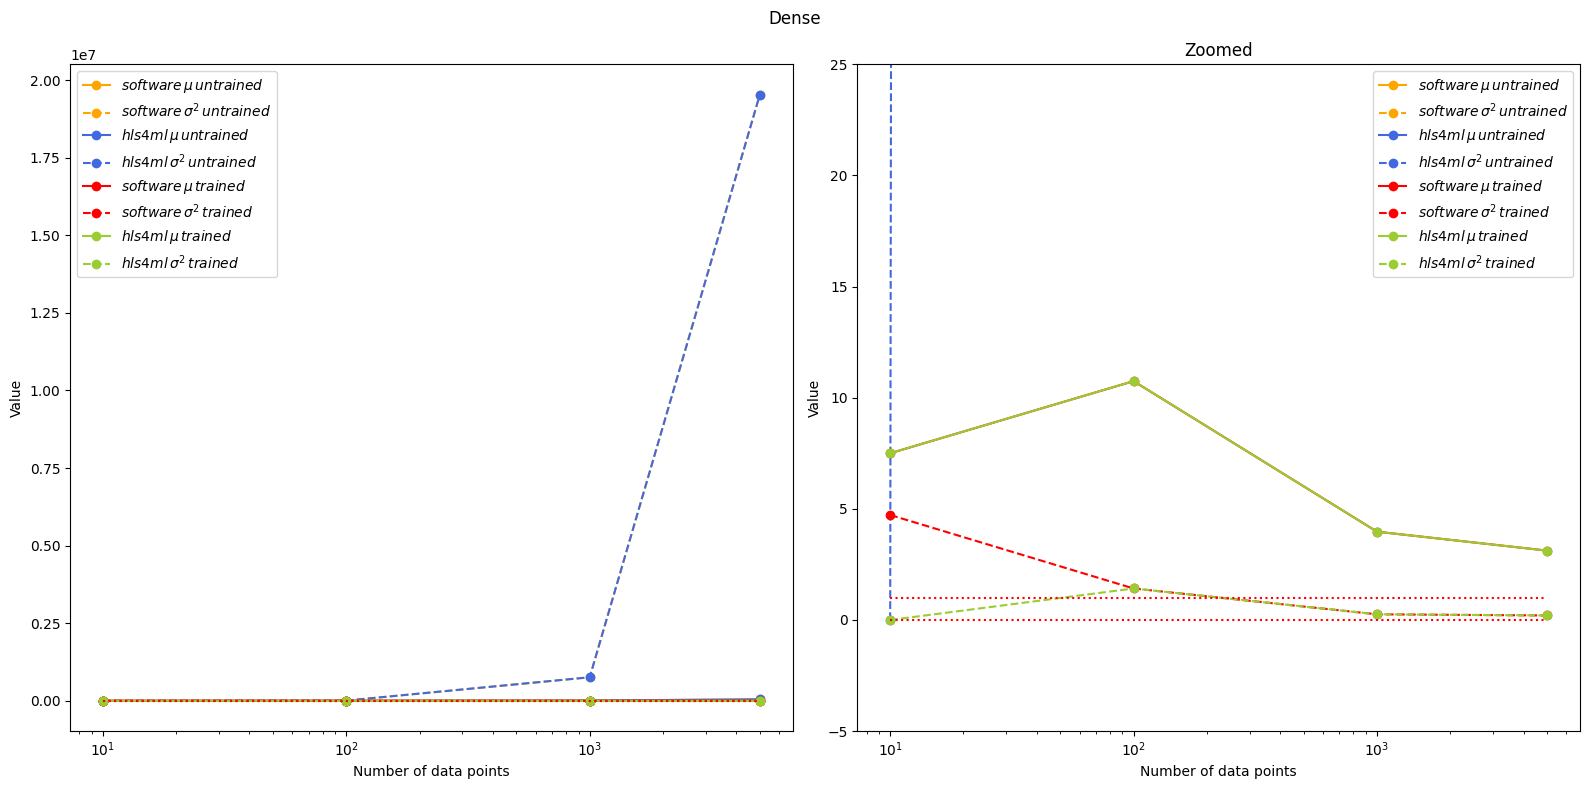

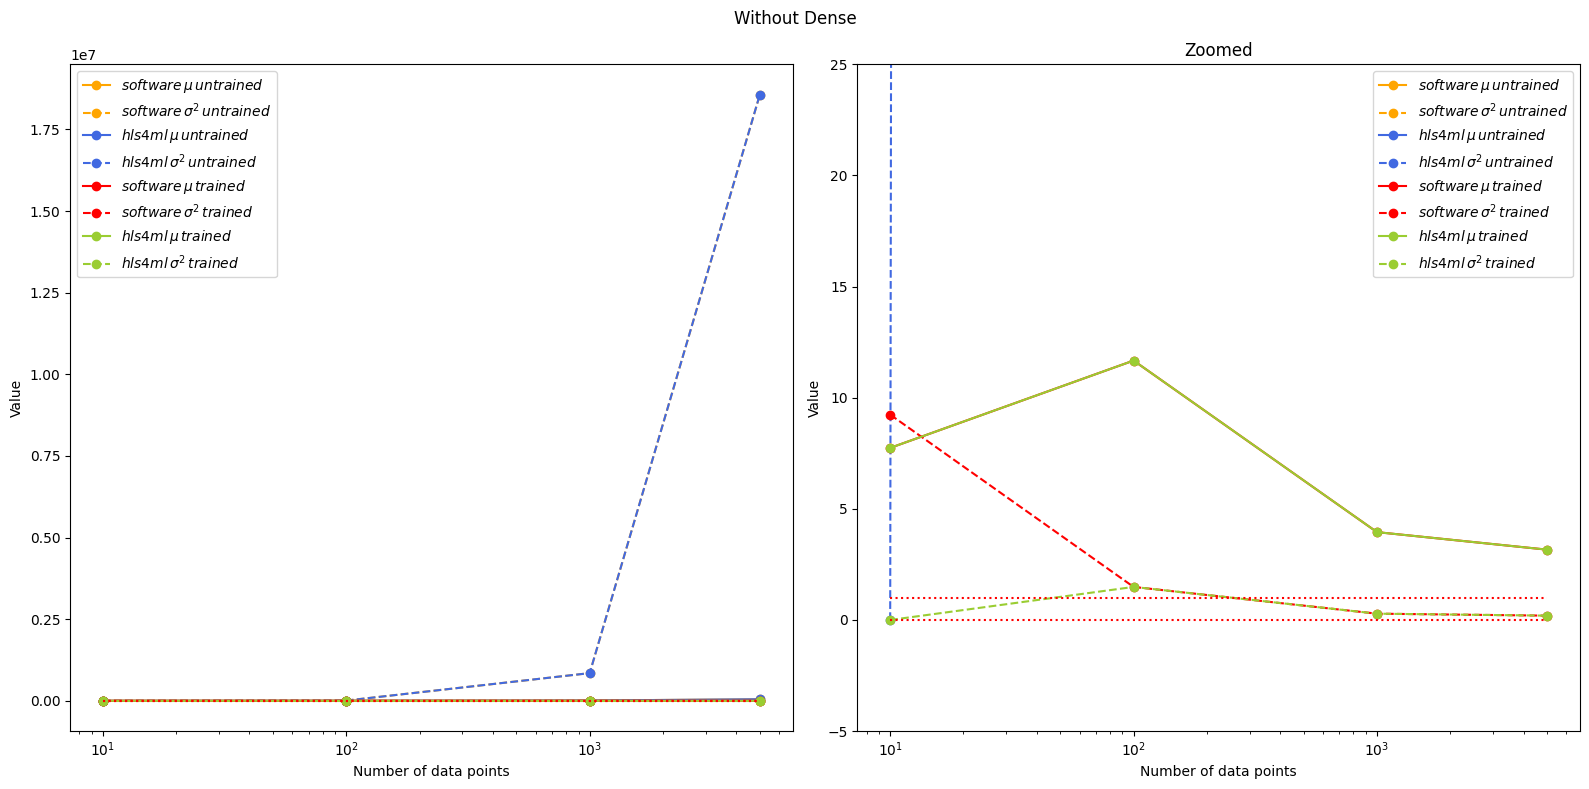

IndexError: list index out of range

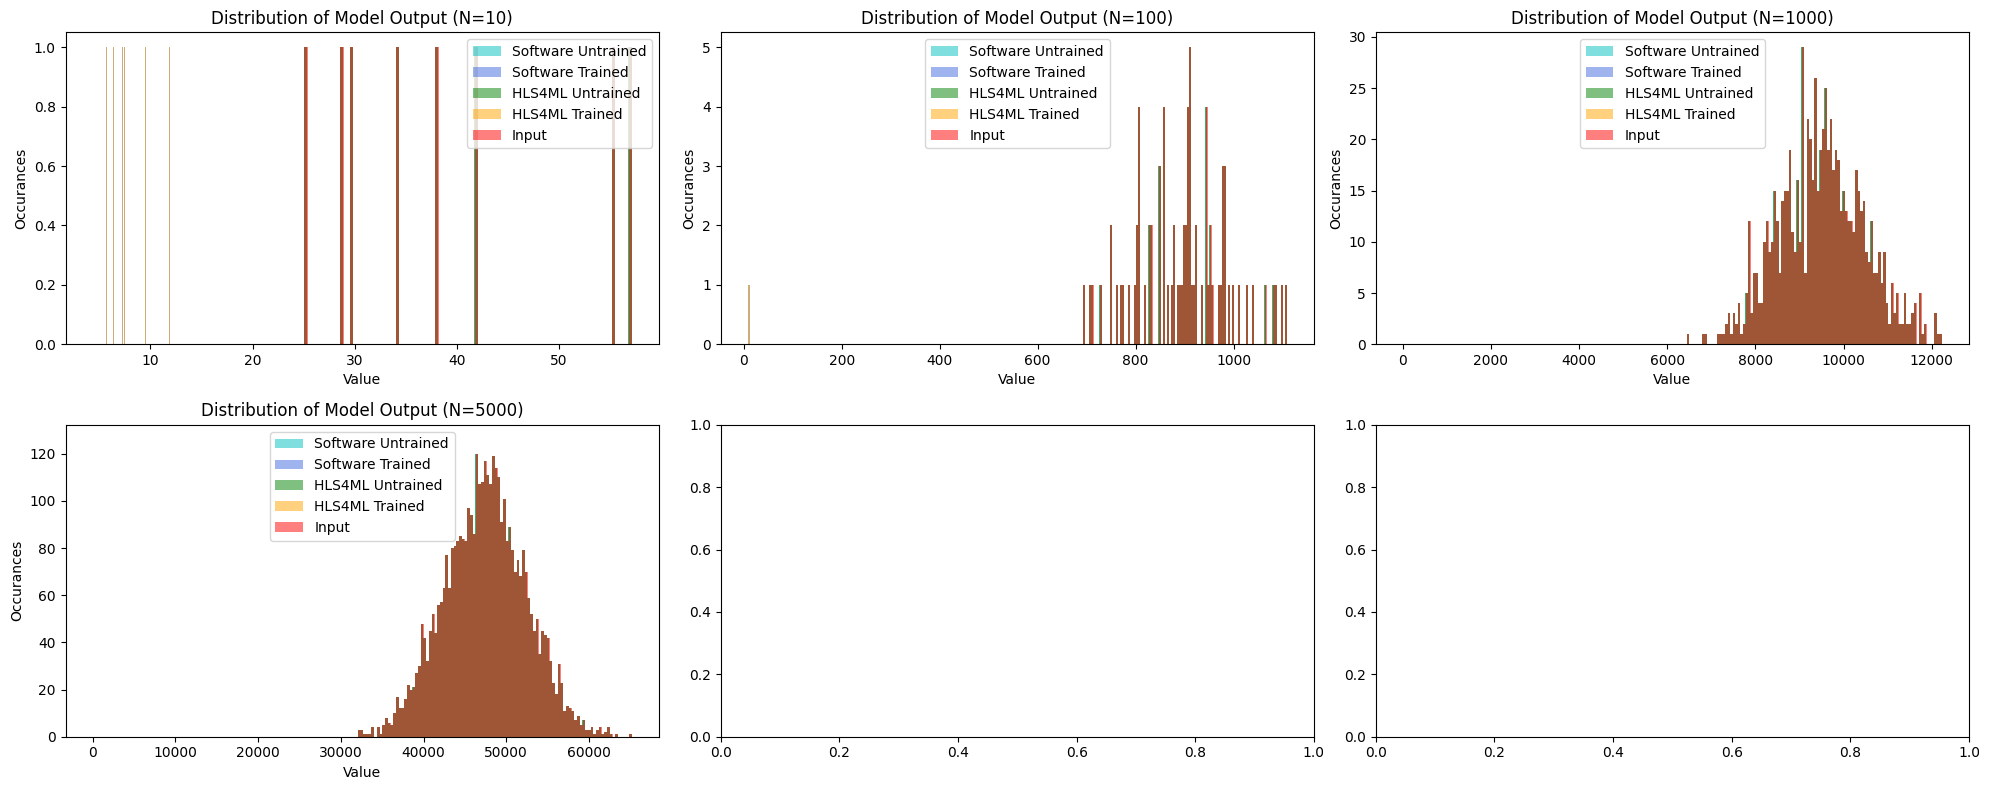

In [34]:
print_mean_and_var('with_dense', data_from_json)
print_mean_and_var('without_dense', data_from_json)
create_mean_variance_plots('with_dense', data_from_json)
create_mean_variance_plots('without_dense', data_from_json)
create_input_output_plots('with_dense', data_from_json, include_input_data=True)
create_input_output_plots('without_dense', data_from_json, include_input_data=True)


In [ ]:

# Create a figure with 2x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Labels for each plot (inside the boxes)
sub_labels = ["", "Zoomed"]

# Set titles for the top and bottom rows]
axs[0].set_title("Not zoomed")
axs[1].set_title("Zoomed")

fig.suptitle("Dense")
plt.tight_layout()

# Create a figure with 2x2 grid of subplots
fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5))

# Labels for each plot (inside the boxes)
sub_labels2 = ["", "Zoomed"]

# Set titles for the top and bottom rows]
axs2[0].set_title("Not zoomed")
axs2[1].set_title("Zoomed")

fig2.suptitle("Dense")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

with_dense
untrained
Software means:  [-49.134583, -50.293762, -50.049515, -50.016872, -50.008945, -49.967415]
Hardware means:  [14.825485229492188, 13.66673583984375, 13.910885009765625, 13.933523895263672, 13.939449890136718, 13.982953165690104]
Software variances:  [26.454258, 23.172176, 24.591309, 24.576954, 24.696184, 24.566278]
Hardware variances:  [0.0, 23.150061577418818, 24.567842759704217, 24.820679381898138, 24.965869426581076, 24.800546320712503]
trained
Software means:  [-32.628105, -18.66782, -2.4691868, -0.013007093, -0.0032416945, 0.0014300046]
Hardware means:  [12.943572998046875, 10.629962158203124, 12.294125518798829, 13.000478698730468, 12.99090185546875, 12.941184641520183]
Software variances:  [47.49244, 8.088564, 1.3194281, 1.0194471, 1.0209503, 1.007152]
Hardware variances:  [0.0, 6.055946134030819, 1.432230910260696, 1.0485237963190301, 1.0509427557424642, 1.0356445106567504]


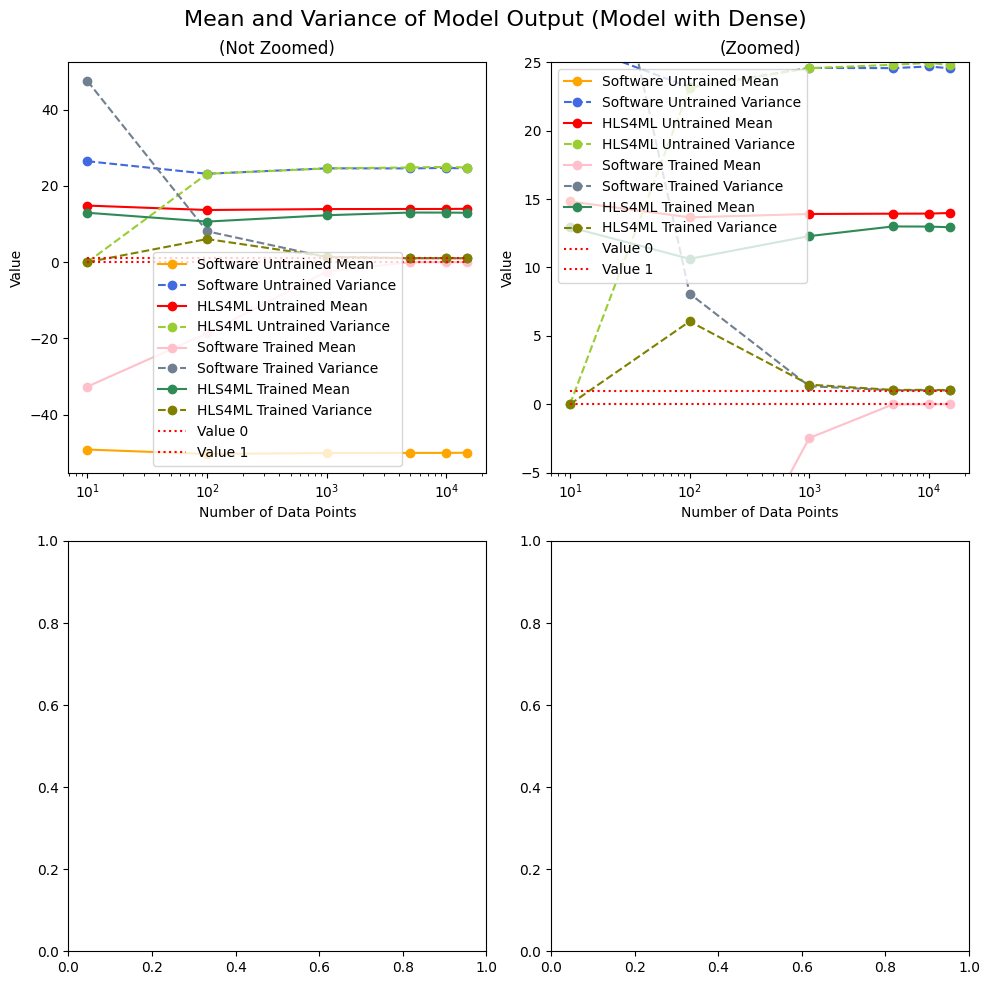

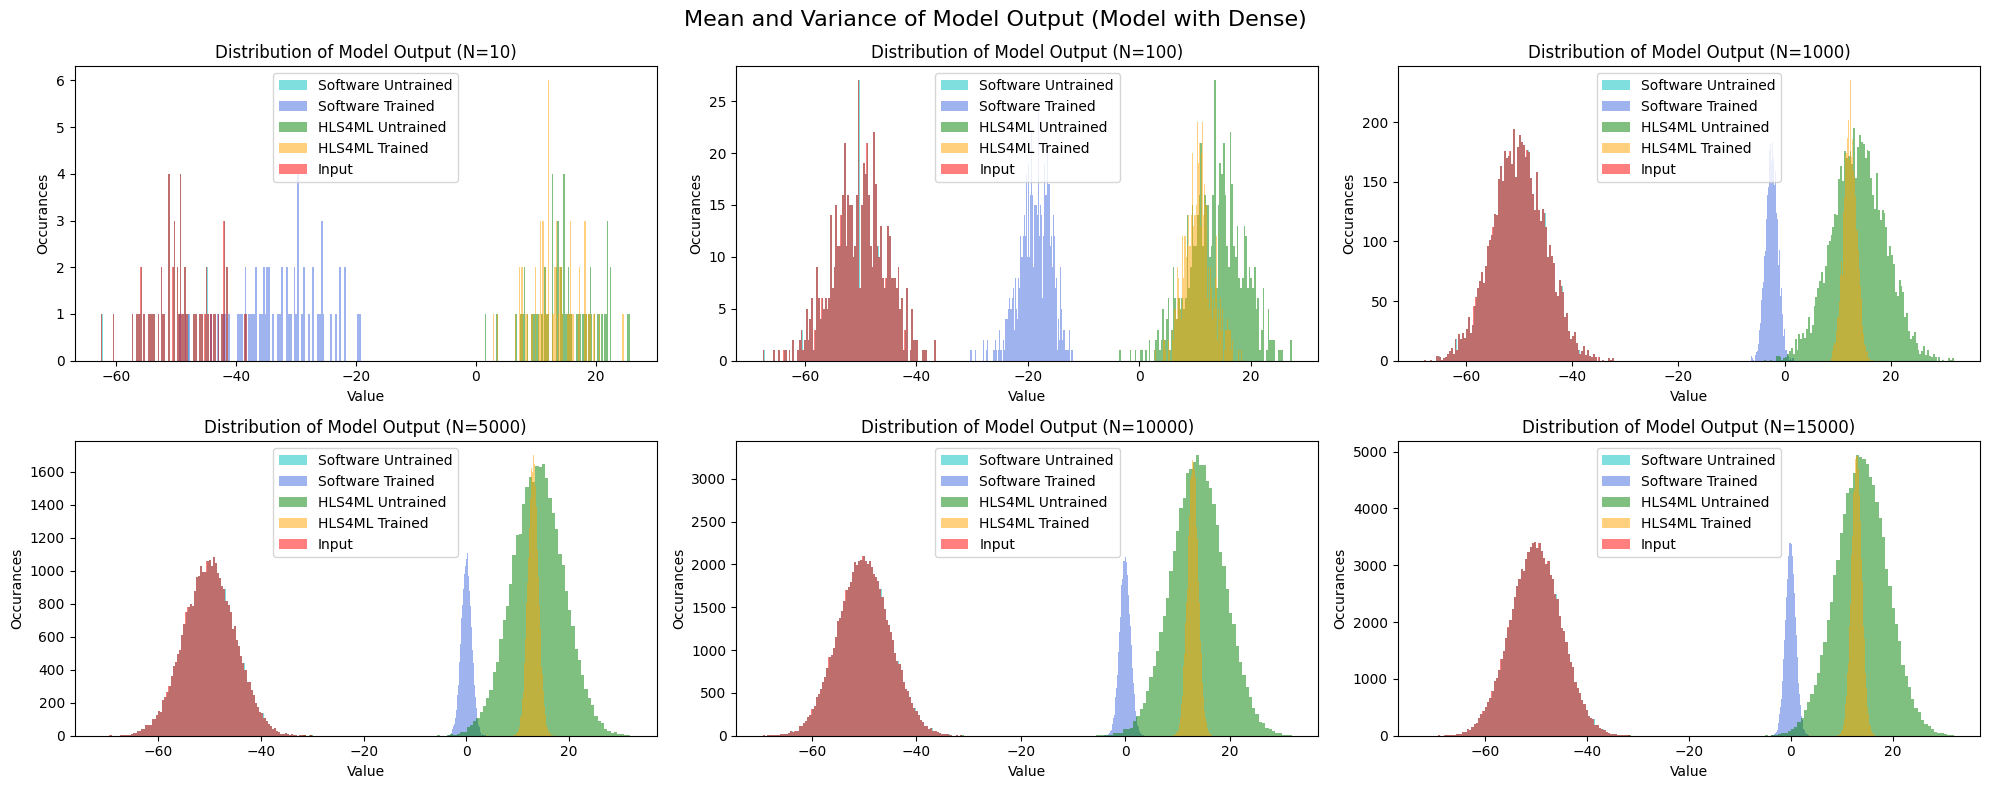

without_dense
untrained
Software means:  [-49.165855, -50.181355, -49.935436, -49.961143, -49.959923, -49.984833]
Hardware means:  [14.794204711914062, 13.779122924804687, 14.004935760498046, 13.98522381591797, 13.991442016601562, 13.96421422322591]
Software variances:  [31.811876, 24.700651, 23.782566, 24.766163, 24.393532, 24.722183]
Hardware variances:  [0.0, 24.676906423689797, 24.281458184963558, 25.07718972748611, 24.592687613552435, 24.993779113437515]
trained
Software means:  [-32.03885, -18.666239, -2.4210365, -0.0055309925, 0.0053397105, -0.0019970601]
Hardware means:  [12.753677368164062, 10.693452453613281, 12.197407379150391, 12.978561279296875, 12.984985214233399, 12.993344095865885]
Software variances:  [35.043537, 7.522097, 1.2472222, 1.0228008, 1.0059439, 1.0223253]
Hardware variances:  [0.0, 6.113349741068669, 1.348492985542398, 1.0651817792272196, 1.0287317991198506, 1.05432096952945]


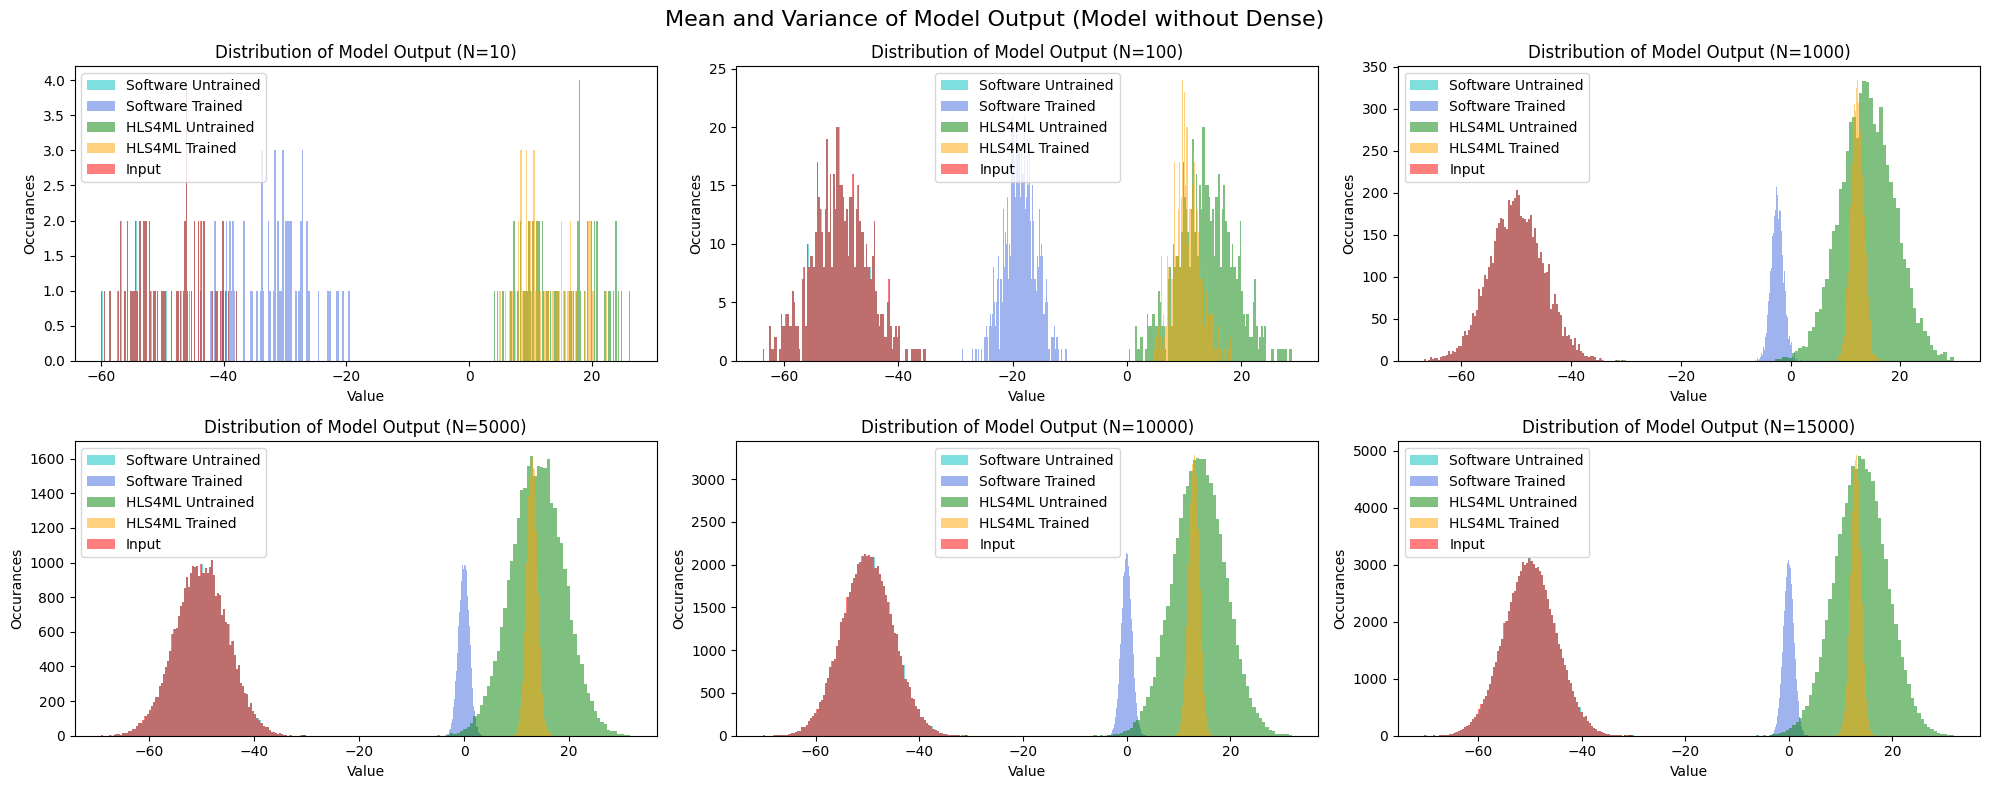

In [ ]:
titles = ['Model with Dense', 'Model without Dense']
colors = ['orange', 'royalblue', 'r', 'yellowgreen', 'pink', 'slategrey', 'seagreen', 'olive', 'darkgoldenrod']

# Plot the mean and variance of the output from all the models
    # as a function of the number of data points
num_cols = 2
num_rows = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10), layout='tight')

for index, (model, title) in enumerate(zip(data, titles)):
    
    results = data[model]['results']

    print(model)
    for scheme in ['untrained', 'trained']:
        print(scheme)
        print("Software means: ", results['software'][scheme]['means'])
        print("Hardware means: ", results['hls4ml'][scheme]['means'])
        print("Software variances: ", results['software'][scheme]['vars'])
        print("Hardware variances: ", results['hls4ml'][scheme]['vars'])

    for i in range(num_rows):
        ax = axes[index, i % num_cols]

        k = 0
        for scheme in ['untrained', 'trained']:
            for j, (type, means, vars) in enumerate(zip(['Software', 'HLS4ML'], [results['software'][scheme]['means'], results['hls4ml'][scheme]['means']], [results['software'][scheme]['vars'], results['hls4ml'][scheme]['vars']])):
                scheme_name = 'Untrained' if scheme == 'untrained' else 'Trained'
                ax.plot(num_data_points, means, label=f'{type} {scheme_name} Mean', marker='o', color=colors[k], linestyle='-')
                ax.plot(num_data_points, vars, label=f'{type} {scheme_name} Variance', marker='o', color=colors[k+1], linestyle='--')
                k += 2

        ax.plot([num_data_points[0], num_data_points[-1]], [0, 0], 'r', linestyle=':', label='Value 0')
        ax.plot([num_data_points[0], num_data_points[-1]], [1, 1], 'r', linestyle=':', label='Value 1')
        ax.set_xscale('log')
        ax.set_xlabel('Number of Data Points')
        if i == 0:
            ax.set_title(f'(Not Zoomed)')
        else:
            ax.set_ylim(-5, 25)
            ax.set_title(f'(Zoomed)')
        ax.set_ylabel('Value')
        ax.legend()
    title = f'Mean and Variance of Model Output ({title})' if i == 0 else f'Mean and Variance of Model Output ({title})'
    fig.suptitle(title, fontsize=16)
    plt.show()

    include_input_data = True

    num_cols = 3
    num_rows = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8), layout='tight')

    inputs = results['inputs']

    untrained_software_outputs = results['software']['untrained']['outputs']
    trained_software_outputs = results['software']['trained']['outputs']

    untrained_hardware_outputs = results['hls4ml']['untrained']['outputs']
    trained_hardware_outputs = results['hls4ml']['trained']['outputs']

    # Plot the distribution of the output from all the models
    for i in range(num_rows * num_cols):
        ax = axes[i // num_cols, i % num_cols]

        # Plot the distribution of the output from all the models
        ax.hist(untrained_software_outputs[i], bins=100, color='c', alpha=0.5, label='Software Untrained')
        ax.hist(trained_software_outputs[i], bins=100, color='royalblue', alpha=0.5, label='Software Trained')
        ax.hist(untrained_hardware_outputs[i], bins=100, color='g', alpha=0.5, label='HLS4ML Untrained')
        ax.hist(trained_hardware_outputs[i], bins=100, color='orange', alpha=0.5, label='HLS4ML Trained')
        if include_input_data:
            ax.hist(inputs[i].flatten(), bins=100, color='r', alpha=0.5, label='Input')

        ax.set_xlabel('Value')
        ax.set_ylabel('Occurances')
        ax.set_title(f'Distribution of Model Output (N={num_data_points[i]})')
        ax.legend()
    fig.suptitle(title, fontsize=16)
    plt.show()

In [ ]:

num_data_points = [10, 100, 1000, 10_000, 25_000, 50_000]
inputs = []
software_outputs = []
hardware_outputs = []
software_means = []
software_vars = []
hls_means = []
hls_vars = []

for i, num in enumerate(num_data_points):
    if i != 3:
        continue

    input_mean = -50
    input_var = 5

    data_x = np.random.normal(loc=input_mean, scale=input_var, size=(num, 64))
    data_y = np.random.uniform(0, 1, size=(num, 64))

    # make 90/10 test split
    split = int(0.9 * len(data_x))
    train_data_x = data_x[:split]
    train_data_y = data_y[:split]
    test_data_x = data_x[split:]
    test_data_y = data_y[split:]

    model_with_dense.load_weights('untrained_model_with_dense.h5')
    adam_W = AdamW(learning_rate=0.0001)
    model_with_dense.compile(optimizer=adam_W, loss=['categorical_crossentropy'], metrics=['accuracy'])

    '''
    # callbacks = all_callbacks(
    #     stop_patience=1000,
    #     lr_factor=0.5,
    #     lr_patience=10,
    #     lr_epsilon=0.000001,
    #     lr_cooldown=2,
    #     lr_minimum=0.0000001,
    #     outputDir='donovan_test',
    # ) ""
    '''

    # Train the model
    model_with_dense.fit(
        data_x,
        data_y,
        batch_size=32,
        epochs=7,
        validation_split=0.25,
        shuffle=True,
        # callbacks=callbacks.callbacks,
        verbose=1
    )

    # Convert the model to hls
    config = hls4ml.utils.config_from_keras_model(model_with_dense, granularity='model')
    print("-----------------------------------")
    print("Configuration")
    plotting.print_dict(config)
    print("-----------------------------------")
    hls_model = hls4ml.converters.convert_from_keras_model(
        model_with_dense, hls_config=config, output_dir='testing_model/hls4ml_prj', part='xcu250-figd2104-2L-e'
    )

    # Compile the hls model
    hls_model.compile()

    software_output = model_with_dense.predict(test_data_x, verbose=1)
    hls_output = hls_model.predict(test_data_x).reshape(software_output.shape)

    inputs.append(train_data_x)

    software_outputs.append(software_output)
    hardware_outputs.append(hls_output)

    software_model_means = np.mean(software_output, axis=1)
    software_model_vars = np.var(software_output, axis=1)

    hls_model_means = np.mean(hls_output, axis=1)
    hls_model_vars = np.var(hls_output, axis=1)

    software_mean_mean = np.mean(software_model_means)
    software_mean_var = np.mean(software_model_vars)

    hls_model_mean_mean = np.mean(hls_model_means)
    hls_model_mean_var = np.mean(hls_model_vars)

    software_means.append(software_mean_mean)
    software_vars.append(software_mean_var)

    hls_means.append(hls_model_mean_mean)
    hls_vars.append(hls_model_mean_var)

    print(test_data_x.shape)
    print(test_data_y.shape)
    print(software_output.shape)
    print(hls_output.shape)
    print(hls_model_vars.shape)

    # print(f'Software Mean: {software_mean_mean}, Software Var: {software_mean_var}')
    # print(f'HLS Mean: {hls_model_mean_mean}, HLS Var: {hls_model_mean_var}')


In [ ]:
print("Software Means:", software_means)
print("Software Variances:", software_vars)
print("HLS4ML Means:", hls_means)
print("HLS4ML Variances:", hls_vars)

colors = ['orange', 'royalblue', 'r', 'c', 'm', 'y', 'k']

for i in range(2):

    for j, (type, linestyle, means, vars) in enumerate(zip(['Software', 'HLS4ML'], ['-', '--'], [software_means, hls_means], [software_vars, hls_vars])):
        plt.plot(num_data_points, means, label=f'{type} Mean', marker='o', color=colors[0], linestyle=linestyle)
        plt.plot(num_data_points, vars, label=f'{type} Variance', marker='o', color=colors[1], linestyle=linestyle)

    plt.plot([num_data_points[0], num_data_points[-1]], [0, 0], 'r', linestyle=':', label='Value 0')
    plt.plot([num_data_points[0], num_data_points[-1]], [1, 1], 'r', linestyle=':', label='Value 1')
    plt.xscale('log')
    plt.xlabel('Number of Data Points')
    if i == 0:
        plt.title(f'Mean and Variance of Model Output')
    else:
        plt.ylim(-5, 15)
        plt.title(f'Mean and Variance of Model Output (Zoomed)')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

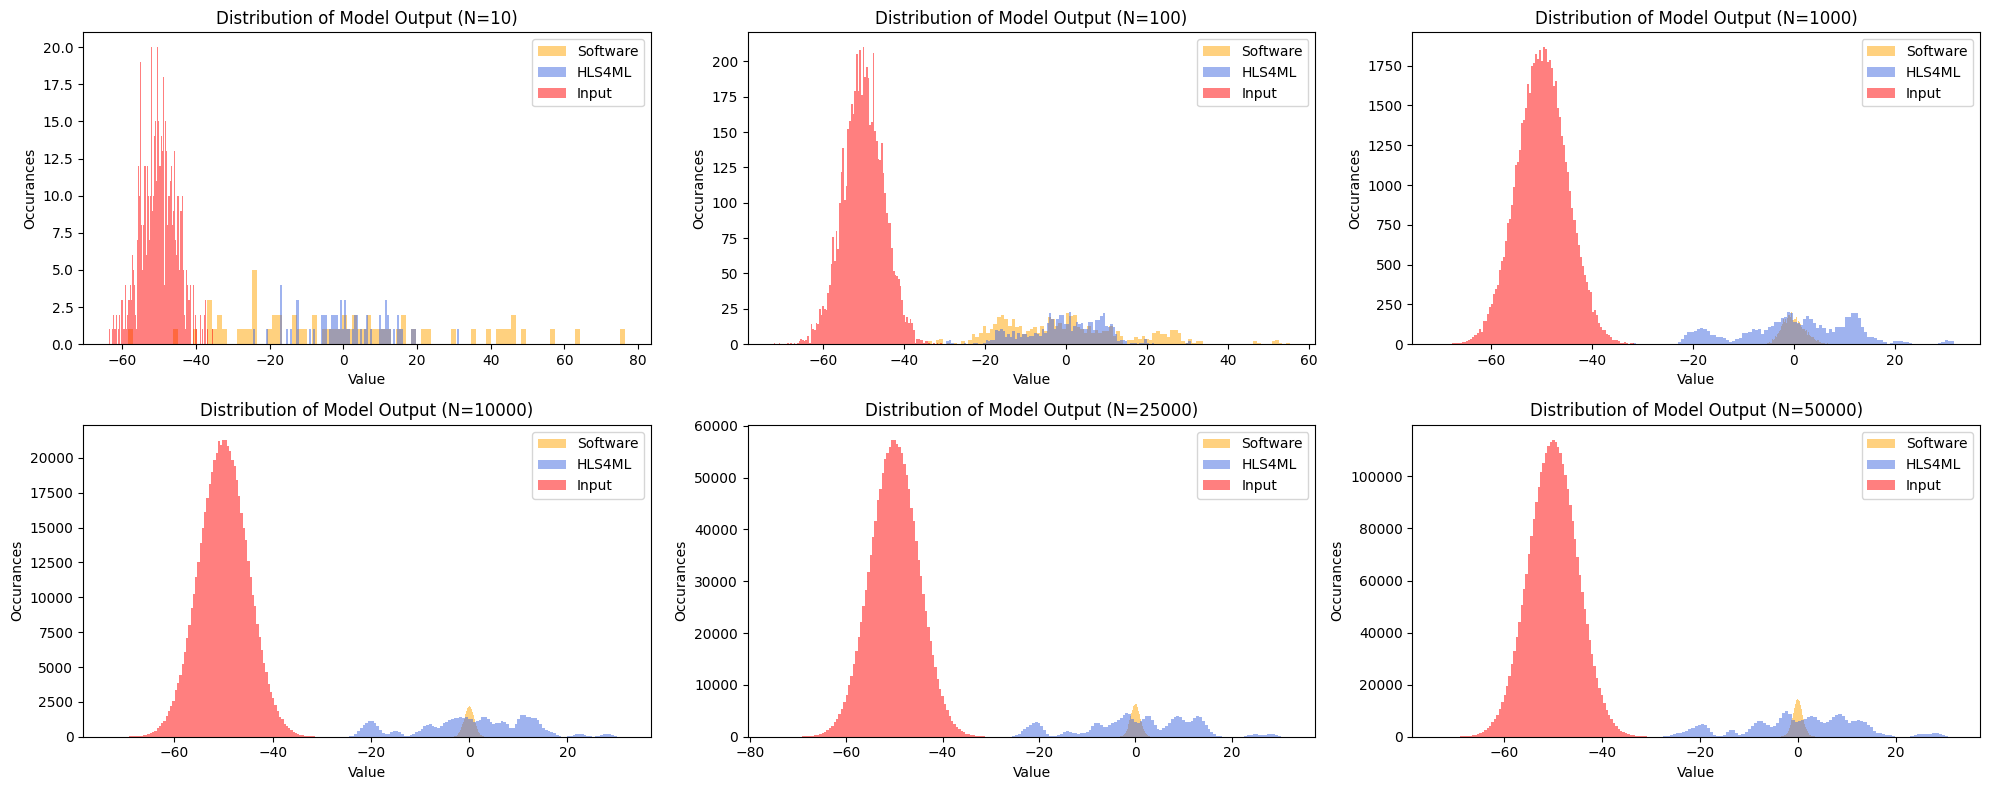

In [225]:
include_input_data = True

num_cols = 3
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8), layout='tight')

for i in range(num_rows * num_cols):
    ax = axes[i // num_cols, i % num_cols]
    ax.hist(software_outputs[i].flatten(), bins=100, color='orange', alpha=0.5, label='Software')
    ax.hist(hardware_outputs[i].flatten(), bins=100, color='royalblue', alpha=0.5, label='HLS4ML')
    if include_input_data:
        ax.hist(inputs[i].flatten(), bins=100, color='r', alpha=0.5, label='Input')
    ax.set_xlabel('Value')
    ax.set_ylabel('Occurances')
    ax.set_title(f'Distribution of Model Output (N={num_data_points[i]})')
    ax.legend()

Interpreting Sequential
Topology:
Layer name: batch_normalization_10_input, layer type: InputLayer, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: batch_normalization_10, layer type: BatchNormalization, input shapes: [[None, 64]], output shape: [None, 64]
-----------------------------------
Configuration
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
-----------------------------------
Interpreting Sequential
Topology:
Layer name: batch_normalization_10_input, layer type: InputLayer, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: batch_normalization_10, layer type: BatchNormalization, input shapes: [[None, 64]], output shape: [None, 64]
Creating HLS model


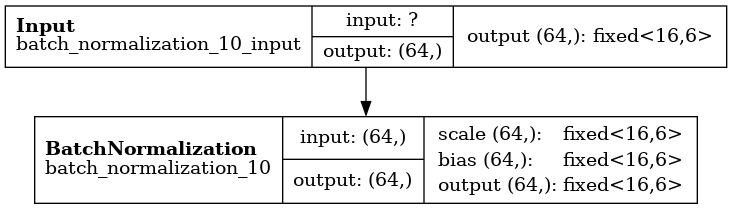

In [233]:
model = Sequential([

    # Dense(64, input_shape=(64,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)),
    BatchNormalization(input_shape=(64,)),
])

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='test2/hls4ml_prj', part='xcu250-figd2104-2L-e'
)
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [123]:
test = hls4ml.converters.get_supported_keras_layers()
print(test)

['SimpleRNN', 'LSTM', 'GRU', 'InputLayer', 'Dense', 'BinaryDense', 'TernaryDense', 'Activation', 'LeakyReLU', 'ThresholdedReLU', 'ELU', 'PReLU', 'Softmax', 'ReLU', 'BatchNormalization', 'Embedding', 'GarNet', 'GarNetStack', 'ZeroPadding1D', 'ZeroPadding2D', 'Flatten', 'Reshape', 'UpSampling1D', 'UpSampling2D', 'Permute', 'QDense', 'QConv1D', 'QConv2D', 'QDepthwiseConv2D', 'QSeparableConv1D', 'QSeparableConv2D', 'QActivation', 'QBatchNormalization', 'QConv2DBatchnorm', 'Sequential', 'Functional', 'Conv1D', 'SeparableConv1D', 'DepthwiseConv1D', 'Conv2D', 'SeparableConv2D', 'DepthwiseConv2D', 'MaxPooling1D', 'MaxPooling2D', 'AveragePooling1D', 'AveragePooling2D', 'GlobalMaxPooling1D', 'GlobalMaxPooling2D', 'GlobalAveragePooling1D', 'GlobalAveragePooling2D', 'Add', 'Subtract', 'Multiply', 'Average', 'Maximum', 'Minimum', 'Concatenate', 'Dot']


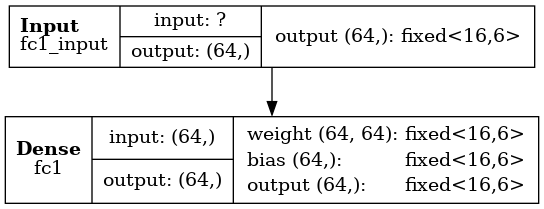

In [124]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [125]:
hls_model.compile()
# X_test = np.ascontiguousarray(X_test)
# y_hls = hls_model.predict(X_test)

Writing HLS project


/home/donovan/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done


In [11]:
# total_mse_list = []
# for i in range(100):
X = tf.random.uniform((1, 64), minval=-25, maxval=25)
# print("Input")
# print(X)

output = np.array(model(X)).reshape(64)
print("Output")
print(output)

hls_output = hls_model.predict(np.ascontiguousarray(X))
print("HLS Output")
print(hls_output)

squared_error = np.square(hls_output - output)
mse = np.mean(squared_error)
print(mse)
# total_mse_list.append(mse)

# total_mse = np.mean(total_mse_list)

# print(f"MSE: {total_mse}")

Output
[ 19.638794    -4.5001645  -18.192532    26.744349    -1.5193158
  -4.446575    -0.56378853  -6.049307    15.5351515    7.0024133
 -15.121836    16.121567     1.7753888   -1.6913851  -24.039412
  20.160719     2.4907093    8.492768   -21.366123    30.268635
   0.88669294  26.586115    -4.901066    -6.471077     0.28286278
   1.683014     7.3943477    6.9853454   12.071368   -10.512304
  -0.20517625   7.765762    -5.8003807    5.8813224   -4.8546414
  17.896784    -6.7892385   -4.726705    -0.13129808  29.26693
  14.2620735    8.908426    34.340187     2.7965055  -16.313412
  19.443565    19.271406    22.159931    13.753034   -14.146069
  -4.5785317    0.7133099    3.679599     9.381757     8.90595
   3.8345623  -16.775068    -1.6887194  -15.905323    12.356643
   1.8683329    5.9456472   -6.596321    -1.251513  ]
HLS Output
[  7.723633    -0.67578125  -9.3359375   31.300781    -2.7050781
  -3.3828125    9.714844   -10.538086     6.326172     9.769531
  -2.116211     6.1152344   

MSE: 1615.1610107421875


In [9]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'donovan' on host 'Donovan-3.localdomain' (Linux_x86_64 version 5.10.102.1-microsoft-standard-WSL2) on Tue Apr 09 10:43:02 PDT 2024
INFO: [HLS 200-10] On os Ubuntu 22.04.4 LTS
INFO: [HLS 200-10] In directory '/home/donovan/code/research/hls4ml/sandbox-dir/model_1/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/donovan/code/research/hls4ml/sandbox-dir/model_1/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.006',
  'BestLatency': '1',
  'WorstLatency': '1',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'DSP': '2926',
  'FF': '12447',
  'LUT': '98360',
  'BRAM_18K': '0',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}

In [10]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')

Found 1 solution(s) in model_1/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Tue Apr  9 11:11:14 2024

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.006|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |    1|    1|    1|    1| function |
    +-----+-----+-----+-----+---